[Deep Learningで背景削除をしてみる](https://tech.fusic.co.jp/posts/2020-01-20-remove-background/)

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F

import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='6'

In [4]:
image_path = './input/kaggle_dogs/dog.100.jpg'
orig_img = cv2.imread(image_path)
orig_img = orig_img[...,::-1]  # BGR->RGB

In [5]:
img_crop_size = 512
h,w,_ = orig_img.shape
resized_img = cv2.resize(orig_img,(img_crop_size,img_crop_size))
print(orig_img.shape)
print(resized_img.shape)

(397, 500, 3)
(512, 512, 3)


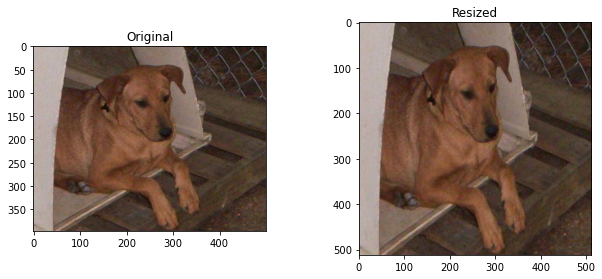

In [6]:
fig=plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Original")
ax.imshow(orig_img)
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Resized")
ax.imshow(resized_img)

In [7]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model = model.to(device)
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [8]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(resized_img)
input_batch = input_tensor.unsqueeze(0).to(device)

In [9]:
with torch.no_grad():
    output = model(input_batch)['out']

In [10]:
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

In [11]:
class_dim = 1
boolean_dog_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['dog'])
print(f"shape = {boolean_dog_masks.shape}, dtype = {boolean_dog_masks.dtype}")

shape = torch.Size([1, 512, 512]), dtype = torch.bool


In [12]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

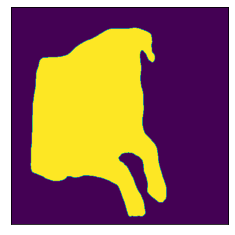

In [13]:
show([m.float() for m in boolean_dog_masks])

In [20]:
mask = boolean_dog_masks[0].float().to('cpu').detach().numpy().copy()
m3 = np.array([mask, mask, mask])
m3 = m3.transpose(1, 2, 0)
print(m3.shape)
resized_img = resized_img / 256
resized_cut_img = resized_img * m3
original_cut_img = cv2.resize(resized_cut_img,(w,h))

(512, 512, 3)


In [21]:
mask.shape

(512, 512)

In [63]:
def trimming_img(img):
    sum_x = np.sum(img, axis=1)
    sum_y = np.sum(img, axis=0)

    x_min = np.nonzero(sum_x)[0].min()
    x_max = np.nonzero(sum_x)[0].max()
    y_min = np.nonzero(sum_y)[0].min()
    y_max = np.nonzero(sum_y)[0].max()

    # 犬を切り取る
    cropped_img = img[x_min:x_max, y_min:y_max, :]

    # 余白を追加して正方形に変更
    cropped_img_h, cropped_img_w = cropped_img[:,:,0].shape
    if cropped_img_h > cropped_img_w:
        add_pad = cropped_img_h - cropped_img_w
        top = bottom =  0
        left = add_pad // 2
        right = add_pad - left
    elif cropped_img_h < cropped_img_w:
        add_pad = cropped_img_w - cropped_img_h
        left = right =  0
        top = add_pad // 2
        bottom = add_pad - top
    print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")
    square_img = cv2.copyMakeBorder(cropped_img, top, bottom, left, right, cv2.BORDER_CONSTANT, (0, 0, 0))

    return square_img
    

In [64]:
print(original_cut_img.shape)
square_img = trimming_img(original_cut_img)
print(square_img.shape)

(397, 500, 3)
top:0, bottom:0, left:16, right:16
(344, 344, 3)


In [ ]:
print(original_cut_img.shape)
square_img = trimming_img(original_cut_img)
print(square_img.shape)

(397, 500, 3)
top:0, bottom:0, left:16, right:16
(344, 344, 3)


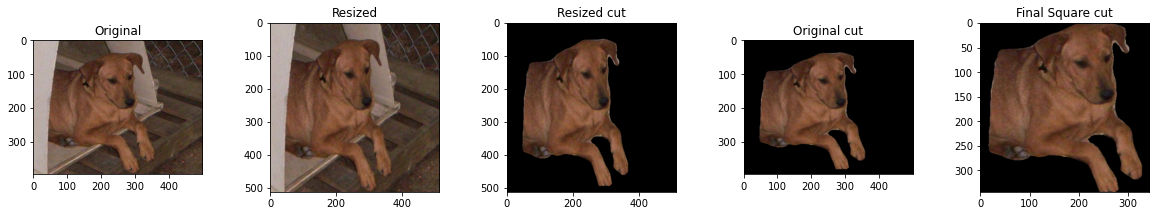

In [65]:
fig=plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax = fig.add_subplot(1, 5, 1)
ax.set_title("Original")
ax.imshow(orig_img)

ax = fig.add_subplot(1, 5, 2)
ax.set_title("Resized")
ax.imshow(resized_img)

ax = fig.add_subplot(1, 5, 3)
ax.set_title("Resized cut")
ax.imshow(resized_cut_img)

ax = fig.add_subplot(1, 5, 4)
ax.set_title("Original cut")
ax.imshow(original_cut_img)

ax = fig.add_subplot(1, 5, 5)
ax.set_title("Final Square cut")
ax.imshow(square_img)